# Import packages

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import measure
from skimage.measure import regionprops, regionprops_table
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.image import load_img
from importlib import reload
import segmenteverygrain as seg
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from tqdm import trange, tqdm

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
gpus

%matplotlib widget


# Load models

In [28]:
model = seg.Unet()
model.compile(optimizer=Adam(), loss=seg.weighted_crossentropy, metrics=["accuracy"])
model.load_weights('/Users/pjlohr/Documents/GitHub/segmenteverygrain/segmenteverygrain/checkpoints/seg_model')

sam_checkpoint = "/Users/pjlohr/Documents/GitHub/segmenteverygrain/segmenteverygrain/checkpoints/sam_vit_h_4b8939.pth"
device = "mps"
model_type = "default"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

# Run segmentation

### Grains are supposed to be well defined in the image; e.g., if a grain consists of only a few pixels, it is unlikely to be detected.

### The segmentation can take a few minutes even for medium-sized images. Images with ~2000 pixels along their largest dimension are a good start and allow the user to get an idea about how well the segmentation works.

### If you have a much larger image, see the section **"Run segmentation on large image"** at the end of the notebook. Running the `predict_large_image` function takes a lot longer (e.g., several hours), but it is possible to analyze very large images with tens of thousands of grains.

### Image used below is available from [here](https://github.com/zsylvester/segmenteverygrain/blob/main/torrey_pines_beach.jpeg).

In [29]:
# reload(seg)

# replace this with the path to your image:
fname = '/Users/pjlohr/Documents/GitHub/segmenteverygrain/perovskite_segmentation/belay_om/modified_om/mod_0.35 M SnO2  60 m min 50 O oC 5 CB M.tiff'

image = np.array(load_img(fname))
image_pred = seg.predict_image(image, model, I=256)

# decreasing the 'dbs_max_dist' parameter results in more SAM prompts (and longer processing times):
labels, coords = seg.label_grains(image, image_pred, dbs_max_dist=1.0) # Unet prediction

segmenting image tiles...


100%|██████████| 5/5 [00:00<00:00,  5.59it/s]


### Use the figure created in the next cell to check the quality of the Unet labeling (sometimes it doesn't work at all) and the distribution of SAM prompts (= black dots). If the Unet prediction is of poor quality, it is a good idea to create some training data and fine tune the base model so that it works better with the images of interest.

In [21]:
fig, ax = plt.subplots(figsize=(15,10))
ax.imshow(image_pred)
plt.scatter(np.axrray(coords)[:,0], np.array(coords)[:,1], c='k')
plt.xticks([])
plt.yticks([]);


# Run SAM segmentation  

creating masks using SAM...


100%|██████████| 769/769 [00:16<00:00, 45.27it/s]


finding overlapping polygons...


535it [00:00, 833.57it/s] 


finding best polygons...


100%|██████████| 150/150 [00:01<00:00, 136.36it/s]


creating labeled image...


100%|██████████| 6/6 [00:00<00:00, 133.08it/s]


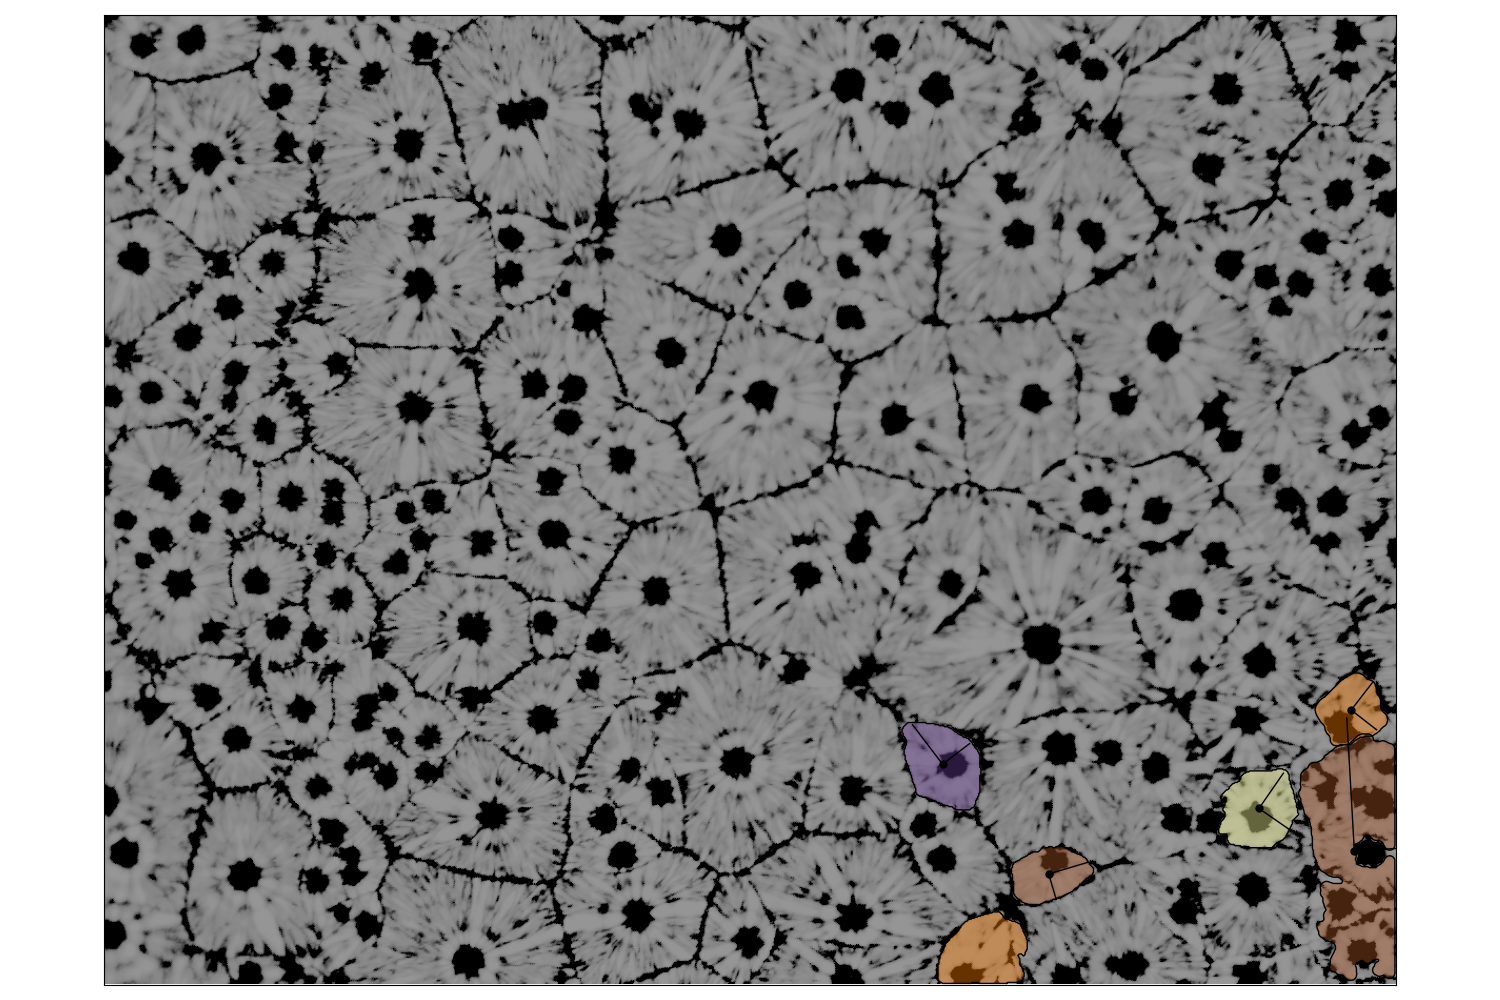

In [39]:
# SAM segmentation, using the point prompts from the Unet:
all_grains, labels, mask_all, grain_data, fig, ax = seg.sam_segmentation(sam, image, image_pred, 
            coords, labels, min_area=2500.0, plot_image=True, remove_edge_grains=False, remove_large_objects=False)

# # plot results again if necessary
# fig, ax = plt.subplots(figsize=(10,8))
# ax.imshow(image)
# seg.plot_image_w_colorful_grains(image, all_grains, ax, cmap='Paired')
# seg.plot_grain_axes_and_centroids(all_grains, labels, ax, linewidth=1, markersize=10)

# Delete or merge grains in segmentation result
* ### click on the grain that you want to remove and press the 'x' key
* ### click on two grains that you want to merge and press the 'm' key (they have to be the last two grains you clicked on)
* ### press the 'g' key to hide the grain masks (so that you can see the original image better); press the 'g' key again to show the grain masks

In [40]:
grain_inds = []
cid1 = fig.canvas.mpl_connect('button_press_event', 
                              lambda event: seg.onclick2(event, all_grains, grain_inds, ax=ax))
cid2 = fig.canvas.mpl_connect('key_press_event', 
                              lambda event: seg.onpress2(event, all_grains, grain_inds, fig=fig, ax=ax))

Run this cell if you do not want to delete / merge existing grains anymore; it is a good idea to do this before moving on to the next step.

In [41]:
fig.canvas.mpl_disconnect(cid1)
fig.canvas.mpl_disconnect(cid2)

Use this function to update the 'labels' array after deleting and merging grains (the 'all_grains' list is updated when doing the deletion and merging):

100%|██████████| 6/6 [00:00<00:00, 177.05it/s]


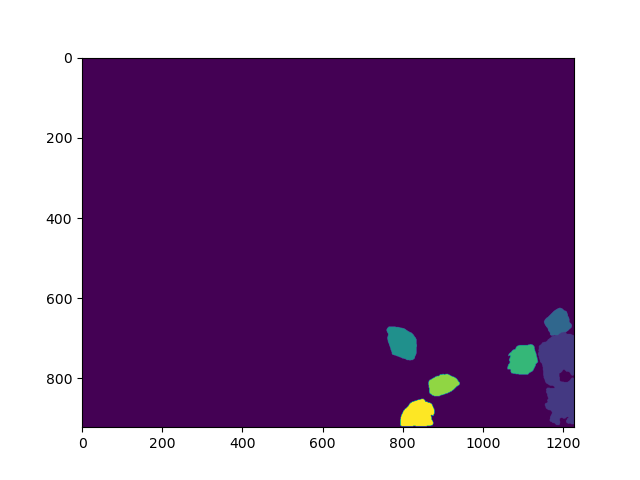

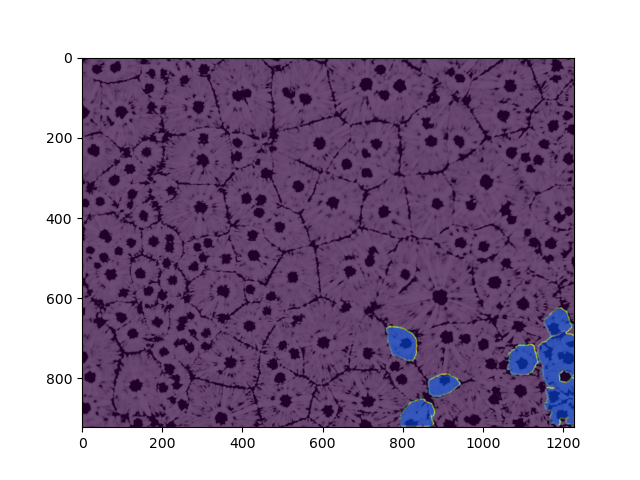

In [42]:
# all_grains, labels, mask_all = seg.get_grains_from_patches(ax, image)

all_grains, labels, mask_all, fig, ax = seg.get_grains_from_patches(ax, image)

Plot the updated set of grains:

100%|██████████| 6/6 [00:00<00:00, 131.98it/s]


(922.0, 0.0)

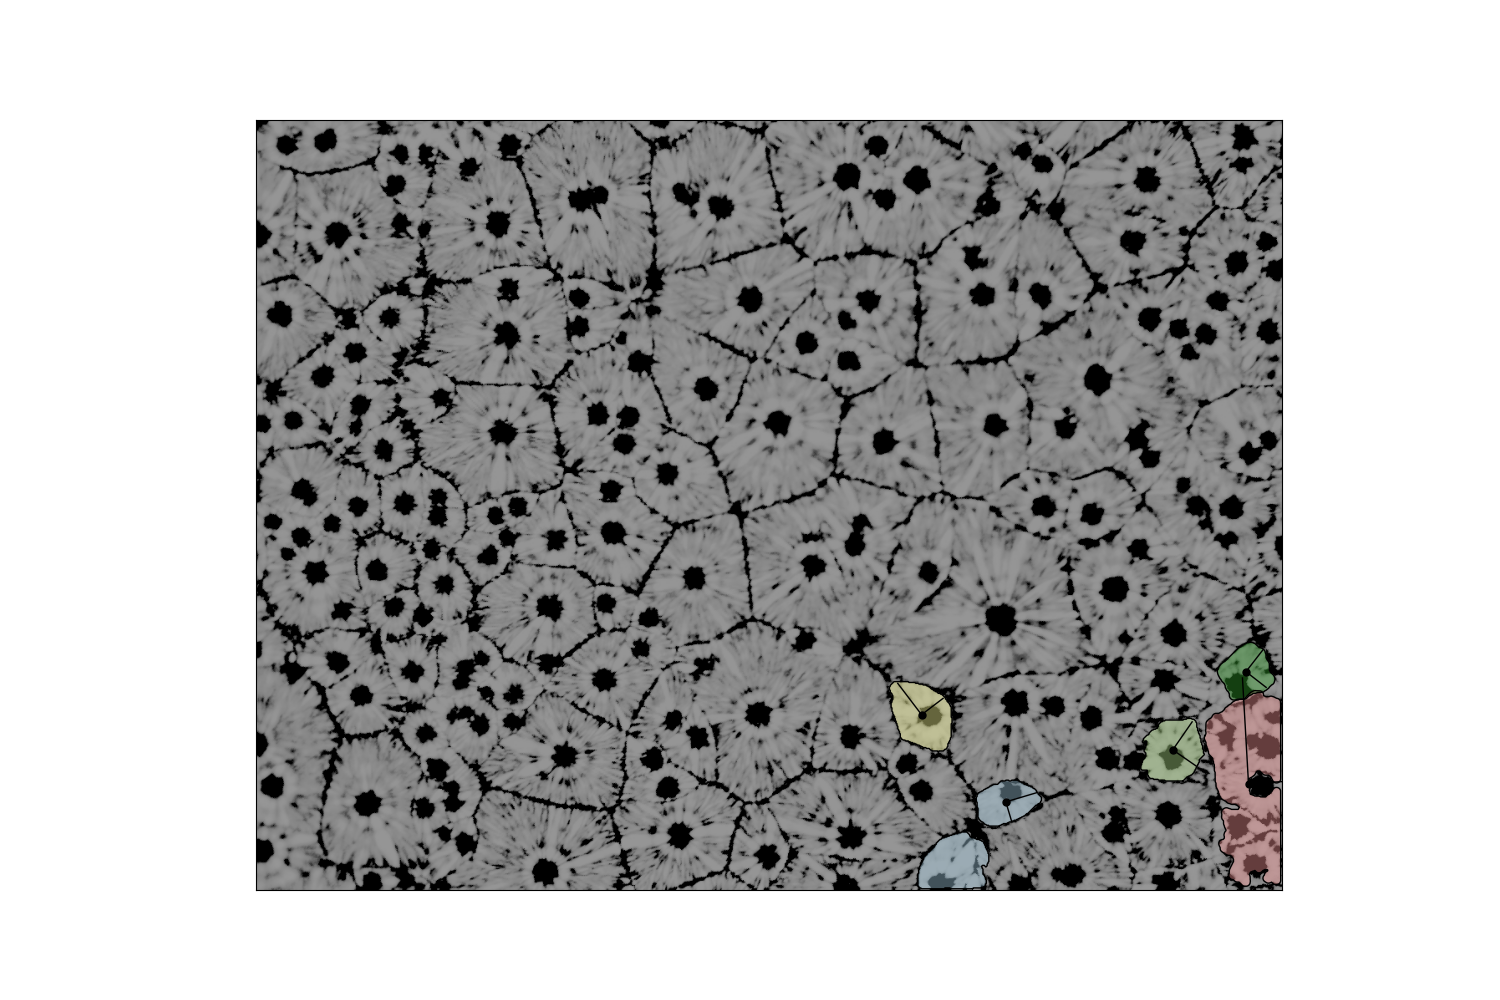

In [43]:
fig, ax = plt.subplots(figsize=(15,10))
plt.xticks([])
plt.yticks([])
seg.plot_image_w_colorful_grains(image, all_grains, ax, cmap='Paired', plot_image=True)
seg.plot_grain_axes_and_centroids(all_grains, labels, ax, linewidth=1, markersize=10)
plt.xlim([0, np.shape(image)[1]])
plt.ylim([np.shape(image)[0], 0])

## Add new grains using the Segment Anything Model

* click on unsegmented grain that you want to add
* press the 'x' key if you want to delete the last grain you added
* press the 'm' key if you want to merge the last two grains that you added
* right click outside the grain (but inside the most recent mask) if you want to restrict the grain to a smaller mask - this adds a background prompt

In [44]:
predictor = SamPredictor(sam)
predictor.set_image(image) # this can take a while
coords = []
cid3 = fig.canvas.mpl_connect('button_press_event', lambda event: seg.onclick(event, ax, coords, image, predictor))
cid4 = fig.canvas.mpl_connect('key_press_event', lambda event: seg.onpress(event, ax, fig))

In [15]:
fig.canvas.mpl_disconnect(cid3)
fig.canvas.mpl_disconnect(cid4)

After you are done with the deletion / addition of grain masks, run this cell to generate an updated set of grains:

In [16]:
all_grains, labels, mask_all = seg.get_grains_from_patches(ax, image)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:00<00:00, 2203.55it/s]
450it [00:00, 1804.74it/s]


## Get grain size distribution

Run this cell and then click (left mouse button) on one end of the scale bar in the image and click (right mouse button) on the other end of the scale bar:

In [131]:
cid5 = fig.canvas.mpl_connect('button_press_event', lambda event: seg.click_for_scale(event, ax))

number of pixels: 1552.77


Use the length of the scale bar in pixels (it should be printed above) to get the scale of the image (in units / pixel):

In [17]:
n_of_units = 1000
units_per_pixel = n_of_units/1552.77 # length of scale bar in pixels

In [49]:
props = regionprops_table(labels.astype('int'), intensity_image = image, properties =\
        ('label', 'area', 'centroid', 'major_axis_length', 'minor_axis_length', 
         'orientation', 'perimeter', 'max_intensity', 'mean_intensity', 'min_intensity'))
grain_data = pd.DataFrame(props)

stats_df = pd.DataFrame()

stats_df['area_px'] = grain_data['area'].values
stats_df['perimeter_px'] = grain_data['perimeter'].values
stats_df['major_axis_length_px'] = grain_data['major_axis_length'].values
stats_df['minor_axis_length_px'] = grain_data['minor_axis_length'].values
stats_df['orientation_px'] = grain_data['orientation'].values

stats_df.to_csv(fname[:-4]+'.csv') # save grain data to CSV file
stats_df.head()

area_px  perimeter_px  major_axis_length_px  minor_axis_length_px  \
0  15281.0    791.771645            253.248840             89.609141   
1   3137.0    219.279221             66.877240             61.304859   
2   4731.0    273.480231             94.363416             64.719258   
3   4364.0    268.308658             81.516588             68.934369   
4   3057.0    218.894444             78.172031             50.485093   

   orientation_px  
0        0.057083  
1       -0.660722  
2        0.650067  
3       -0.605263  
4       -1.281990

## Save mask and grain labels to PNG files

In [28]:
dirname = '/Users/zoltan/Dropbox/Segmentation/images/'
# write grayscale mask to PNG file
cv2.imwrite(dirname + fname.split('/')[-1][:-4] + '_mask.png', mask_all)
# Save the image as a PNG file
cv2.imwrite(dirname + fname.split('/')[-1][:-4] + '_image.png', cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

True

### Finetuning the base model

In [ ]:
# # patchify images and masks
# input_dir = "./Masks_and_images/" # the input directory should contain files with 'image' and 'mask' in their filenames
# patch_dir = "./New_project/" # a directory called "Patches" will be created here
# image_dir, mask_dir = seg.patchify_training_data(input_dir, patch_dir)

In [ ]:
# # create training, validation, and test datasets
# train_dataset, val_dataset, test_dataset = seg.create_train_val_test_data(image_dir, mask_dir, augmentation=True)

In [ ]:
# # load base model weights and train the model with the new data
# weights_dir = './checkpoints/seg_model'
# model = seg.create_and_train_model(weights_dir, train_dataset, val_dataset, test_dataset, epochs=100)

In [ ]:
# # save finetuned model as new model (this then can be loaded using "model.load_weights('./new_model/seg_model')"
# model.save_weights('./new_model/seg_model')